In [1]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import pickle
import albumentations as A
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
import cv2
import random

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def generate_triplets(files, num_of_samples = 100):
    keys_count = {}
    samples = []
    duplicate_count = 0
    for i in tqdm(range(num_of_samples)):
        sample_idx = np.random.randint(0,len(files))
        class_name = files[sample_idx][1]
        for tries in range(10):
            anchor_positive_indices = np.random.choice(np.where(files[:,1]==class_name)[0],size=2,replace=False)
            negative_idx = np.random.choice(np.where(files[:,1]!=class_name)[0], size=1, replace=False)[0]
            triplet = (anchor_positive_indices[0],anchor_positive_indices[1],negative_idx)
            triplet_key = "-".join([str(anchor_positive_indices[0]),str(anchor_positive_indices[1]),str(negative_idx)])
            if triplet_key not in keys_count.keys():
                keys_count[triplet_key] = 0
                break
        keys_count[triplet_key] += 1
        if keys_count[triplet_key]>1:
            duplicate_count += 1
        samples.append(triplet)
    print("Duplicate Count:", duplicate_count)
    return samples

def fetch_files(directory, classes):
    files = [(os.path.join(directory,class_,file),class_) for class_ in classes for file in sorted(os.listdir(os.path.join(directory,class_)))]
    class_wise = {}
    for file in files:
        if file[1] not in class_wise.keys():
            class_wise[file[1]] = []
        class_wise[file[1]].append(file[0])
    return np.array(files), class_wise

def get_model(name):
    if name == "efficientnet-b0":
        model = torchvision.models.efficientnet.efficientnet_b0(pretrained=True)
    elif name == "efficientnet-b1":
        model = torchvision.models.efficientnet.efficientnet_b1(pretrained=True)
    elif name == "efficientnet-b2":
        model = torchvision.models.efficientnet.efficientnet_b2(pretrained=True)
    elif name == "efficientnet-b3":
        model = torchvision.models.efficientnet.efficientnet_b3(pretrained=True)
    elif name == "efficientnet-b4":
        model = torchvision.models.efficientnet.efficientnet_b4(pretrained=True)
    elif name == "efficientnet-b5":
        model = torchvision.models.efficientnet.efficientnet_b5(pretrained=True)
    elif name == "efficientnet-b6":
        model = torchvision.models.efficientnet.efficientnet_b6(pretrained=True)
    elif name == "efficientnet-b7":
        model = torchvision.models.efficientnet.efficientnet_b7(pretrained=True)
    elif name == "resnet34":
        model = torchvision.models.efficientnet.resnet34(pretrained=True)
    elif name == "squeezenet1_1":
        model = torchvision.models.efficientnet.squeezenet1_1(pretrained=True)
    return model

class LeafyLoader(Dataset):
    def __init__(self, files, transforms):
        self.files = files
        self.transforms = transforms
        
    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        file = self.files[index]
        img = cv2.imread(file[0])
        label = file[1]
        return (
            np.transpose(self.transforms(image=img)["image"],(2,0,1)),
            label
        )
    
class LeafyTripletLoader(Dataset):
    def __init__(self, files, triplets, transforms):
        self.files = files
        self.triplets = triplets
        self.transforms = transforms
        
    def __len__(self):
        return len(self.triplets)

    def __getitem__(self, index):
        triplet = self.triplets[index]
        anchor = cv2.imread(self.files[triplet[0]][0])
        positive = cv2.imread(self.files[triplet[1]][0])
        negative = cv2.imread(self.files[triplet[2]][0])
        return (
            np.transpose(self.transforms(image=anchor)["image"],(2,0,1)),
            np.transpose(self.transforms(image=positive)["image"],(2,0,1)),
            np.transpose(self.transforms(image=negative)["image"],(2,0,1))
        )
    

class LeafyModel(torch.nn.Module):
    def __init__(self, name="efficientnet-b0"):
        super(LeafyModel, self).__init__()
        model = get_model(name)
        self.embedder = torch.nn.Sequential(
            model,
            torch.nn.Linear(1000, 1024),
            torch.nn.PReLU(),
            torch.nn.Linear(1024, 512)
        )

    def forward(self, x):
        x = self.embedder(x)
        return x


In [3]:
base_dir = "/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/"

classes = sorted(os.listdir(base_dir+"train/"))
classes = [c for c in classes if "." not in c]

train_files, classwise = fetch_files(base_dir+"train/", classes)
valid_files, _ = fetch_files(base_dir+"valid", classes)
print("Total Training Files:",len(train_files))
print("Total Validation Files:",len(valid_files))

Total Training Files: 70295
Total Validation Files: 17572


In [4]:
train_triplets = generate_triplets(train_files, 50000)
valid_triplets = generate_triplets(valid_files, 10000)
with open('train_triplets.pkl', 'wb') as f:
    pickle.dump(train_triplets, f)
with open('valid_triplets.pkl', 'wb') as f:
    pickle.dump(valid_triplets, f)


100%|██████████| 50000/50000 [02:50<00:00, 293.91it/s]


Duplicate Count: 0


100%|██████████| 10000/10000 [00:08<00:00, 1151.42it/s]


Duplicate Count: 0


In [5]:
train_transforms = A.Compose([
            A.Resize(256,256),
            A.transforms.FancyPCA(p=0.2),
            A.transforms.PixelDropout(p=0.2),
            A.augmentations.geometric.transforms.VerticalFlip(p=0.5),
            A.augmentations.geometric.transforms.HorizontalFlip(p=0.5),
            A.Rotate(p=0.2,limit=(-10, 10),border_mode=0,value=0,mask_value=0),#
            A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.2),
            A.Normalize(always_apply=True, p=1.0, mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
            ], p=1.0)
valid_transforms = A.Compose([
            A.Resize(256,256),
            A.Normalize(always_apply=True, p=1.0, mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
            ], p=1.0)

train_dataset = LeafyTripletLoader(train_files, train_triplets, train_transforms)
valid_dataset = LeafyTripletLoader(valid_files, valid_triplets, valid_transforms)
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=32,shuffle=True,num_workers=2)
valid_loader = torch.utils.data.DataLoader(valid_dataset,batch_size=32,shuffle=False,num_workers=2)


In [6]:
epochs = 20
learning_rate = 1e-4
model_name = "efficientnet-b0"
KNN_K = 3

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = LeafyModel(name=model_name)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.TripletMarginLoss()
model.to(device)
criterion.to(device)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth
100%|██████████| 20.5M/20.5M [00:02<00:00, 9.11MB/s]


TripletMarginLoss()

In [7]:

train_losses = []
valid_losses = []
for epoch in range(epochs):

    accum_iter = 4
    bar = tqdm(train_loader, total=len(train_loader))
    model.train()
    train_loss = 0
    for batch_idx,data in enumerate(bar):
        anchor, positive, negative = data[0].to(device),data[1].to(device),data[2].to(device)
        anchor_emb = model(anchor)
        positive_emb = model(positive)
        negative_emb = model(negative)
        loss = criterion(anchor_emb, positive_emb, negative_emb)
        loss = loss / accum_iter
        loss.backward()
        if ((batch_idx + 1) % accum_iter == 0) or (batch_idx + 1 == len(train_loader)):
            optimizer.step()
            optimizer.zero_grad()
        loss_np = loss.detach().cpu().numpy()*accum_iter
        train_loss+=loss_np
        bar.set_description('loss: %.5f:' % (loss_np))

    model.eval()
    test_loss = 0

    with torch.no_grad():
        for data in tqdm(valid_loader, total=len(valid_loader)):
            
            anchor, positive, negative = data[0].to(device),data[1].to(device),data[2].to(device)
            anchor_emb = model(anchor)
            positive_emb = model(positive)
            negative_emb = model(negative)
            loss = criterion(anchor_emb, positive_emb, negative_emb)
            test_loss+=loss.item()
    print("Training Loss:",train_loss/len(train_loader))
    print("Validation Loss:",test_loss/len(valid_loader))

    train_losses.append(train_loss/len(train_loader))
    valid_losses.append(test_loss/len(valid_loader))
    torch.save( model.state_dict(), f"./{model_name}_{epoch+1}.pth")

100%|██████████| 313/313 [01:56<00:00,  2.69it/s]


Training Loss: 0.09829316250574718
Validation Loss: 0.026969978127616662


100%|██████████| 313/313 [01:04<00:00,  4.84it/s]


Training Loss: 0.025935058535022454
Validation Loss: 0.017839399151527845


100%|██████████| 313/313 [01:12<00:00,  4.30it/s]


Training Loss: 0.015475276526318707
Validation Loss: 0.012920646336131963


100%|██████████| 313/313 [01:14<00:00,  4.20it/s]


Training Loss: 0.011454292657050428
Validation Loss: 0.011134717458734116


100%|██████████| 313/313 [01:08<00:00,  4.54it/s]


Training Loss: 0.011056834604216933
Validation Loss: 0.00922694907020837


100%|██████████| 313/313 [01:08<00:00,  4.56it/s]


Training Loss: 0.009830866955215933
Validation Loss: 0.007796688868214909


100%|██████████| 313/313 [01:03<00:00,  4.93it/s]


Training Loss: 0.00777756530965511
Validation Loss: 0.0062952993776851564


100%|██████████| 313/313 [01:07<00:00,  4.65it/s]


Training Loss: 0.008287660238915197
Validation Loss: 0.008411524490045664


100%|██████████| 313/313 [01:06<00:00,  4.71it/s]


Training Loss: 0.006631652209061655
Validation Loss: 0.009606481217347775


100%|██████████| 313/313 [01:08<00:00,  4.58it/s]


Training Loss: 0.008198100313191526
Validation Loss: 0.007886041039095138


100%|██████████| 313/313 [01:04<00:00,  4.87it/s]


Training Loss: 0.008510403740276378
Validation Loss: 0.007703679390608693


100%|██████████| 313/313 [01:06<00:00,  4.71it/s]


Training Loss: 0.005891240175076959
Validation Loss: 0.010582802727961312


100%|██████████| 313/313 [01:04<00:00,  4.88it/s]


Training Loss: 0.007972521310575636
Validation Loss: 0.014462000455338353


100%|██████████| 313/313 [01:05<00:00,  4.81it/s]


Training Loss: 0.006623012529148631
Validation Loss: 0.008458967121264423


100%|██████████| 313/313 [01:07<00:00,  4.65it/s]


Training Loss: 0.006236390204133701
Validation Loss: 0.008007475362418177


100%|██████████| 313/313 [01:04<00:00,  4.82it/s]


Training Loss: 0.006690970709593878
Validation Loss: 0.009496691984871325


100%|██████████| 313/313 [01:05<00:00,  4.80it/s]


Training Loss: 0.006058720570303123
Validation Loss: 0.013057591530461661


100%|██████████| 313/313 [01:05<00:00,  4.78it/s]


Training Loss: 0.007709098068171408
Validation Loss: 0.005247902565489943


100%|██████████| 313/313 [01:05<00:00,  4.81it/s]


Training Loss: 0.0048862262482987865
Validation Loss: 0.0061721572289451625


100%|██████████| 313/313 [01:05<00:00,  4.77it/s]

Training Loss: 0.006125023558745381
Validation Loss: 0.007720286663347921


# Testing Begins from Here

In [8]:
test_dir = "/kaggle/input/plant-disease-expert/Image Data base/Image Data base/"
classes = sorted(os.listdir(test_dir))

test_files, test_classwise = fetch_files(test_dir, classes)
print("Test Files:",len(test_files))

Test Files: 199665


In [9]:
test_transforms = A.Compose([
            A.Resize(256,256),
            A.Normalize(always_apply=True, p=1.0, mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
            ], p=1.0)

In [10]:
samples_per_class = []
for idx in range(len(classes)):
    samples = test_files[test_files[:,1]==classes[idx]]
    for i in range(KNN_K):
        samples_per_class.append(samples[i])
samples_per_class = np.array(samples_per_class)


train_dataset = LeafyLoader(samples_per_class, test_transforms)
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=1,shuffle=False,num_workers=2)

test_dataset = LeafyLoader(test_files, test_transforms)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=1,shuffle=False,num_workers=2)

In [11]:
embeddings_samples = []
embeddings_classes = []
with torch.no_grad():
    for data in tqdm(train_loader, total=len(train_loader)):
        embeddings_classes.append(data[1][0])
        embedding = model(data[0].to(device))[0].cpu().numpy()
        embeddings_samples.append(embedding)
# embeddings_classes
embedding_keys_2_labels = {}
unique_count = 0
for i in range(len(embeddings_classes)):
    if embeddings_classes[i] not in embedding_keys_2_labels.keys():
        embedding_keys_2_labels[embeddings_classes[i]] = unique_count
        unique_count+=1

embeddings_samples = np.array(embeddings_samples)
y_train = [embedding_keys_2_labels[emb_class] for emb_class in embeddings_classes]


100%|██████████| 174/174 [00:02<00:00, 59.32it/s]


In [12]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=KNN_K)
knn.fit(embeddings_samples, y_train)

KNeighborsClassifier(n_neighbors=3)

In [13]:
embeddings_test = []
y_pred = []
classes_test = []
with torch.no_grad():
    for data in tqdm(test_loader, total=len(test_loader)):
        classes_test.append(data[1][0])
        embedding = model(data[0].to(device))[0].cpu().numpy()
        y_pred.append(knn.predict(np.array([embedding]))[0])

y_test = np.array([embedding_keys_2_labels[emb_class] for emb_class in classes_test])

100%|██████████| 199665/199665 [1:02:31<00:00, 53.22it/s]


In [14]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

print(classification_report(y_test, y_pred))
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6048
           1       1.00      1.00      1.00      5964
           2       1.00      1.00      1.00      2640
           3       0.94      0.99      0.96      3948
           4       0.08      0.64      0.14       120
           5       0.62      0.90      0.73      3438
           6       0.99      0.99      0.99      3606
           7       0.09      0.25      0.13       120
           8       0.16      0.19      0.17       189
           9       0.98      1.00      0.99      2526
          10       0.99      0.99      0.99      2052
          11       0.99      0.89      0.94      3918
          12       1.00      0.81      0.90      2790
          13       0.03      0.35      0.06       147
          14       0.96      0.99      0.98     11328
          15       0.99      0.96      0.98     13284
          16       1.00      0.97      0.99     10332
          17       0.98    

<Axes: >

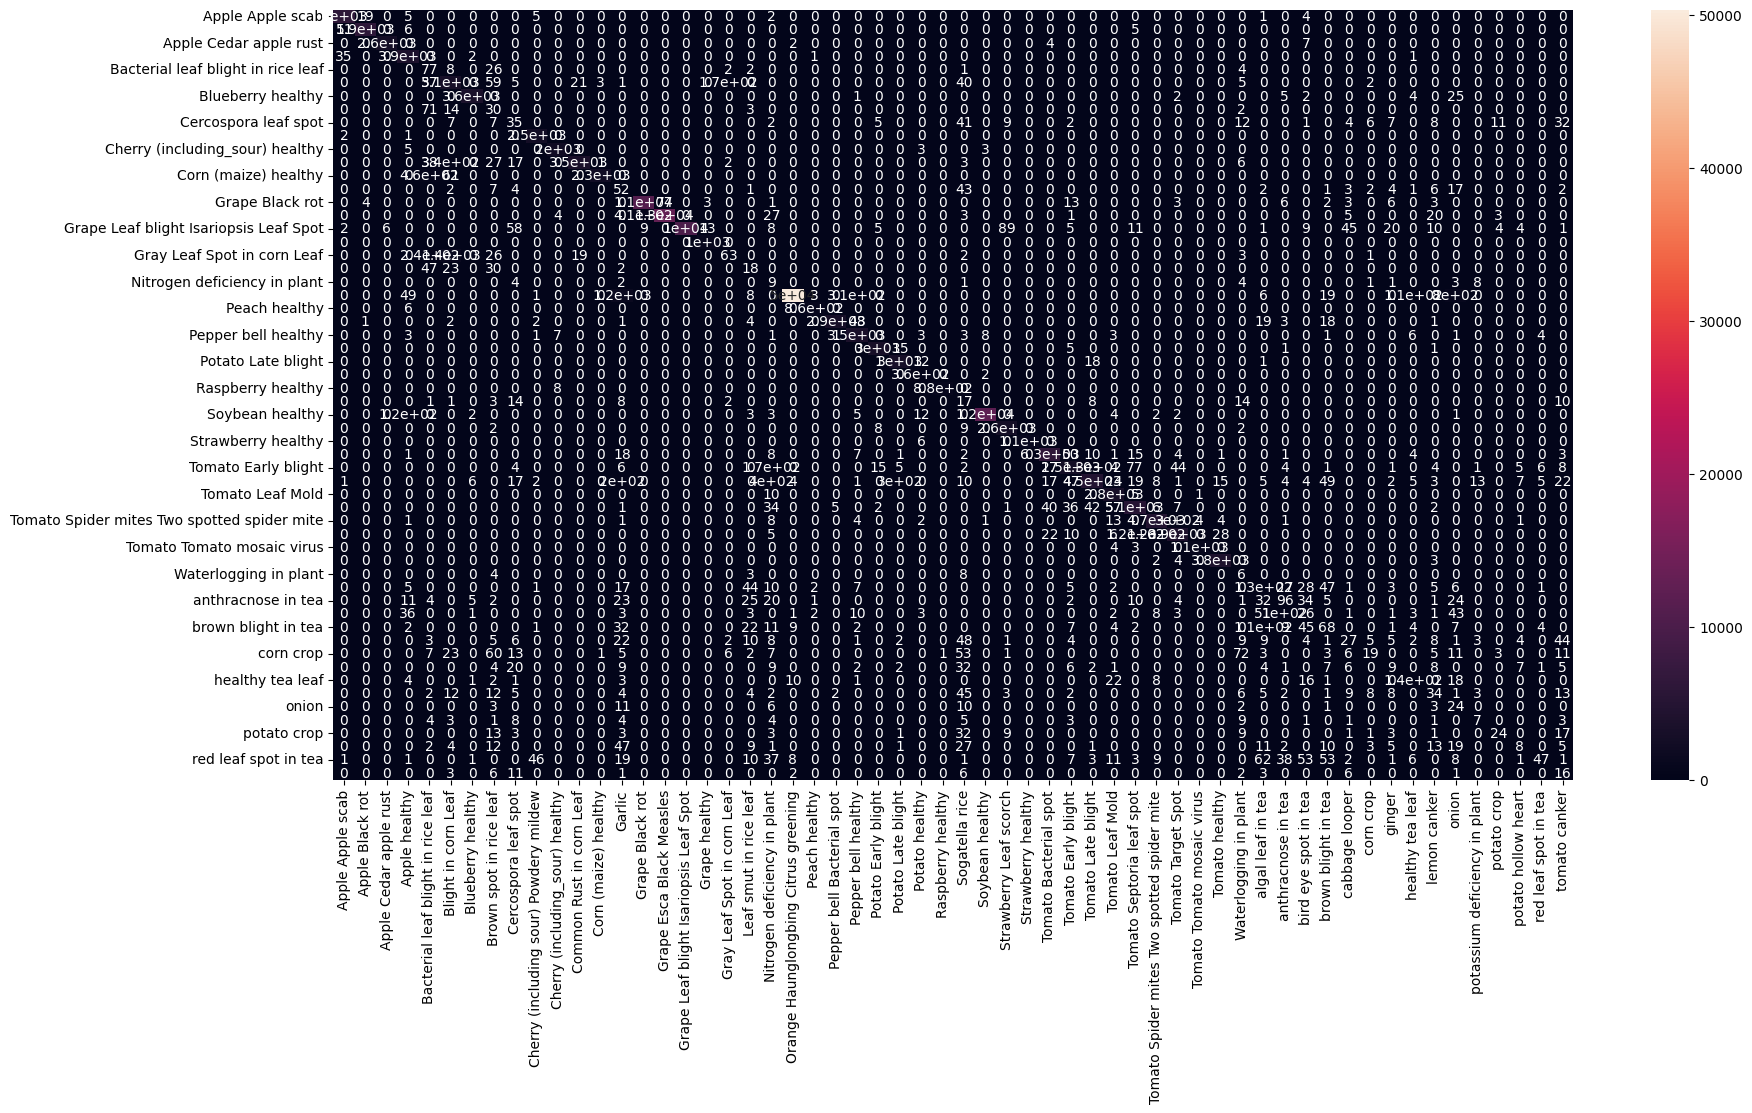

In [15]:
import seaborn as sn
df_cm = pd.DataFrame(cm, index = list(embedding_keys_2_labels.keys()),
                  columns = list(embedding_keys_2_labels.keys()))
plt.figure(figsize=(20,10))
sn.heatmap(df_cm, annot=True)